## Mushroom predictor

In the context of this project, our primary objective is to leverage a dataset encompassing various mushroom characteristics. Through advanced data science methodologies, we aim to develop a predictive model capable of discerning whether a given mushroom is likely to be poisonous or not. 

This project was inspired by the article https://towardsdatascience.com/shap-for-categorical-features-7c63e6a554ea

We start by importing the necessary data.

In [1]:
#importing data from uciml repo
from ucimlrepo import fetch_ucirepo 
import pandas as pd
# fetch dataset 
mushroom = fetch_ucirepo(id=73) 
# metadata 
print(mushroom.metadata) 
# variable information 
print(mushroom.variables) 

{'uci_id': 73, 'name': 'Mushroom', 'repository_url': 'https://archive.ics.uci.edu/dataset/73/mushroom', 'data_url': 'https://archive.ics.uci.edu/static/public/73/data.csv', 'abstract': 'From Audobon Society Field Guide; mushrooms described in terms of physical characteristics; classification: poisonous or edible', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 8124, 'num_features': 22, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['poisonous'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1981, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5959T', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': "This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family (pp. 500-525).  Each species is identified as definitely edible, definitely po

Providing context for those less familiar with mushrooms, the structure of these fungi is intricately divided into distinct parts, as illustrated in the figure below:

<img src="anatomy.jpg" alt="anatomy" style="width:40%; height:40%;" >

Understanding these structural components is crucial, as they play a fundamental role in evaluating the potential toxicity of a mushroom. Now, as we proceed with our analysis, the initial step involves segregating the features from the target variable, laying the groundwork for a comprehensive exploration of the dataset.


In [2]:
X = mushroom.data.features 
y = mushroom.data.targets 
data = pd.concat([X,y],axis=1)
display(data)

#save data (as pandas dataframes)
data.to_csv('mushroom.csv', index = False)

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,poisonous
0,x,s,n,t,p,f,c,n,k,e,...,w,w,p,w,o,p,k,s,u,p
1,x,s,y,t,a,f,c,b,k,e,...,w,w,p,w,o,p,n,n,g,e
2,b,s,w,t,l,f,c,b,n,e,...,w,w,p,w,o,p,n,n,m,e
3,x,y,w,t,p,f,c,n,n,e,...,w,w,p,w,o,p,k,s,u,p
4,x,s,g,f,n,f,w,b,k,t,...,w,w,p,w,o,e,n,a,g,e
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,k,s,n,f,n,a,c,b,y,e,...,o,o,p,o,o,p,b,c,l,e
8120,x,s,n,f,n,a,c,b,y,e,...,o,o,p,n,o,p,b,v,l,e
8121,f,s,n,f,n,a,c,b,n,e,...,o,o,p,o,o,p,b,c,l,e
8122,k,y,n,f,y,f,c,n,b,t,...,w,w,p,w,o,e,w,v,l,p


In [3]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import shap
shap.initjs()

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.inspection import PartialDependenceDisplay, partial_dependence

import warnings

The data imported is a dataframe where every variable is a categorical type. When working with categorical data in machine learning, it is essential to convert these variables into a numerical format that algorithms can understand. Two commonly used techniques for encoding categorical variables are one-hot and label encoding.

We apply One-Hot Encoding when:

1. The categorical feature is not ordinal
2. The number of categorical features is less so one-hot encoding can be effectively applied

We apply Label Encoding when:

1. The categorical feature is ordinal (like Jr. kg, Sr. kg, Primary school, high school)
2. The number of categories is quite large as one-hot encoding can lead to high memory consumption

In this case, let's transform these categorical variables using the One-Hot Encoder

In [4]:
#original feature data
X.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,x,s,n,t,p,f,c,n,k,e,...,s,w,w,p,w,o,p,k,s,u
1,x,s,y,t,a,f,c,b,k,e,...,s,w,w,p,w,o,p,n,n,g
2,b,s,w,t,l,f,c,b,n,e,...,s,w,w,p,w,o,p,n,n,m
3,x,y,w,t,p,f,c,n,n,e,...,s,w,w,p,w,o,p,k,s,u
4,x,s,g,f,n,f,w,b,k,t,...,s,w,w,p,w,o,e,n,a,g


In [5]:
#fit encoder
encoder = OneHotEncoder()
encoder.fit(X)

#transform categorical features
X_encoded = encoder.transform(X).toarray()

#create feature matrix
Xcolumns = X.columns
new_columns = encoder.get_feature_names_out(Xcolumns)

X_encoded = pd.DataFrame(X_encoded, columns= new_columns)

display(X_encoded.head())


,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Take note that the 'cap-shape' feature, originally containing 6 distinct values in the original DataFrame, has been transformed by the encoder. Now, we observe 6 separate columns, each representing a binary classification corresponding to the unique values found in the original feature. This was made for every categorical column.

Now we have to transform the class column (poisonous) in binary values. p --> 1, e --> 0

In [6]:
# Convert class to binary classification
class_mapping = {'e': 0, 'p': 1}
warnings.filterwarnings("ignore")
y['poisonous'] = y['poisonous'].map(class_mapping)
y = np.ravel(y)

With the encoded feature table (X_encoded) and the class vector (y) in hand, we can now split the data into training and testing sets. Subsequently, we will employ the Random Forest algorithm to make predictions on the output.

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, train_size=0.5, random_state=0)

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=0, 
                               n_estimators=100, 
                               max_depth=3, 
                               min_samples_split=5,
                               min_samples_leaf=3,
                               max_features=5,
                               )
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

Now, to assess the quality of the model's predictions, we commonly employ a classification report.

This report provides a detailed breakdown of the model's performance, allowing the calculation of crucial metrics such as accuracy, precision, recall, and F1-score.

- Accuracy: This metric represents the ratio of correctly predicted observations to the total observations, offering an overall measure of model performance.

- Precision: Defined as the ratio of correctly predicted positive observations to the total predicted positives, precision measures the accuracy of positive predictions.

- Recall (Sensitivity or True Positive Rate): It represents the ratio of correctly predicted positive observations to all actual positives, indicating the model's ability to capture all positive instances.

- F1-score: This metric is the harmonic mean of precision and recall, providing a balanced measure that accounts for both false positives and false negatives.

- Support: The support metric indicates the number of actual occurrences of a class in the specified dataset.


In [8]:
# Generate a classification report
classes = ["edible", "poisonous"]
report = classification_report(y_test, y_pred, target_names=classes)
print(report)


              precision    recall  f1-score   support

      edible       0.97      1.00      0.98      2110
   poisonous       1.00      0.97      0.98      1952

    accuracy                           0.98      4062
   macro avg       0.99      0.98      0.98      4062
weighted avg       0.98      0.98      0.98      4062



Examining the classification report reveals a noteworthy accuracy of 98%, signifying the model's adeptness in predicting outputs based on the provided features.

To further unravel the intricacies of the model's decision-making process in determining the edibility of mushrooms, we turn to visual aids such as permutance importances, SHAP values, and partial dependence plots. These tools offer insights into the factors influencing the model's predictions and enhance our understanding of the intricate relationships between features and outcomes.

Let's start with the permutation importances:

In [9]:
perm = PermutationImportance(model, n_iter=10, random_state=0).fit(X_encoded,y)
weights_html = eli5.show_weights(perm, feature_names = X_encoded.columns.tolist())
weights_html

Weight,Feature
0.0523 ± 0.0041,odor_n
0.0368 ± 0.0028,gill-size_b
0.0314 ± 0.0027,gill-size_n
0.0234 ± 0.0025,odor_f
0.0232 ± 0.0017,spore-print-color_h
0.0116 ± 0.0005,odor_p
0.0051 ± 0.0009,cap-surface_s
0.0037 ± 0.0013,stalk-root_b
0.0034 ± 0.0012,cap-surface_f
0.0030 ± 0.0011,stalk-color-above-ring_g


The importance values are currently stored in an HTML-formatted weights object. Our next step involves transforming this data into a pandas DataFrame for more accessible and structured analysis.

In [10]:
weights_df = pd.DataFrame(eli5.explain_weights_df(perm, feature_names = X_encoded.columns.tolist()))
display(weights_df)

,feature,weight,std
0,odor_n,0.052253,0.002055
1,gill-size_b,0.036792,0.001378
2,gill-size_n,0.031376,0.001358
3,odor_f,0.023412,0.001253
4,spore-print-color_h,0.023166,0.000867
...,...,...,...
112,stalk-surface-below-ring_k,-0.001329,0.000453
113,ring-type_p,-0.001366,0.000323
114,stalk-surface-above-ring_k,-0.001748,0.000189
115,stalk-color-below-ring_w,-0.001957,0.000223


Due to the One-Hot Encoding process, our dataset has expanded to include 117 distinct features, each contributing to the determination of importances.

To streamline our analysis, we will group these importances and aggregate the values by summing them. This consolidation will provide a clearer overview of the collective impact of different features on the model.

In [11]:
# Creating a new Dataframe to store the summed importances
summed_importances = pd.DataFrame(columns=['feature','summed_importance'])

for feat in X.columns.values:
    common_feature = X_encoded.filter(regex=feat, axis=1) # filter features by the common name
    encoded_variables = common_feature.columns.values # get the encoded variables
    select_rows = weights_df[weights_df.isin(encoded_variables).any(axis=1)] # select rows that contain the encoded variables
    sum_feature = select_rows.sum(axis=0)[1] # sum the weights
    warnings.filterwarnings("ignore")
    summed_importances = summed_importances.append({'feature': feat, 'summed_importance': sum_feature}, ignore_index=True) # append to dataframe
summed_importances = summed_importances.sort_values(by='summed_importance', ascending=False) # sort dataframe by summed importance
summed_importances

,feature,summed_importance
4,odor,0.087826
7,gill-size,0.068168
19,spore-print-color,0.027339
10,stalk-root,0.009995
1,cap-surface,0.008530
20,population,0.006462
13,stalk-color-above-ring,0.004665
8,gill-color,0.003385
6,gill-spacing,0.002893
2,cap-color,0.002511


Text(0, 0.5, 'Importance')

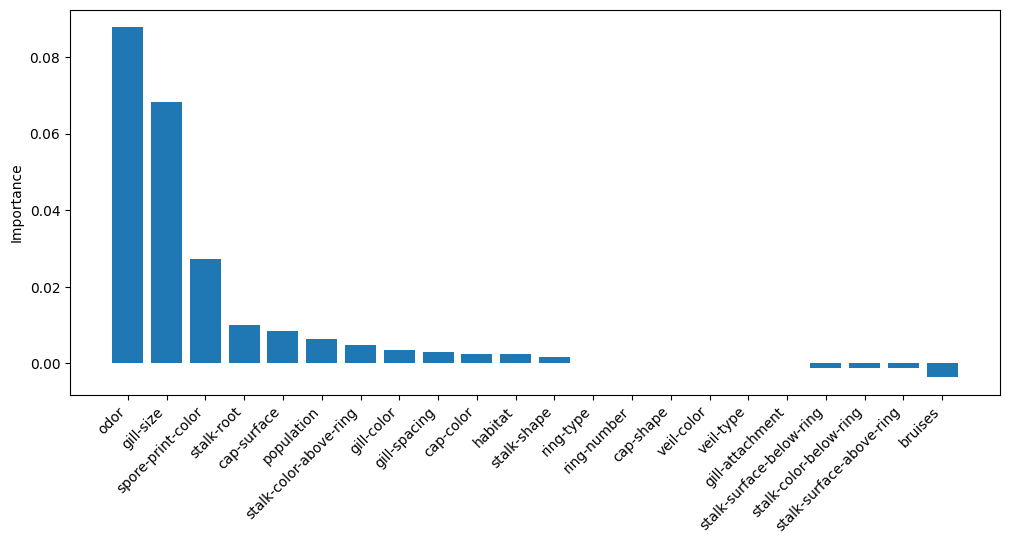

In [12]:
# Plot summed importances
plt.figure(figsize=(12, 5))
plt.bar(x = summed_importances['feature'], height = summed_importances['summed_importance'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Importance')

The significance of feature importances lies in their ability to illuminate the variables that wield considerable influence over the model's predictions. In this specific instance, the analysis revealed that "odor," "gill-size," and "spore-print-color" stand out as pivotal and distinctive features that strongly impact the model's decision-making process. Features exhibiting higher permutation importances are indicative of their heightened relevance in steering the overall performance of the model.

In the given context, the toxicity of mushrooms appears to be closely associated with the inherent characteristics of the species itself. These characteristics, influenced by factors such as the color of spores and odor, play a crucial role in determining the model's predictions.

On a related note, the presence of negative importances in the feature analysis suggests a potential negative correlation between those specific features and the target variable. This could signify either a lesser contribution to predictive accuracy or an inversely proportional relationship with the target variable.

It's important to acknowledge that these insights are drawn from the dataset and analysis at hand. For a more comprehensive understanding, consulting expert sources is recommended. In a pertinent article¹, the authors underscore the significance of spore color and microscopic morphology for definitive mushroom identification.

[1] Beuhler, M.C. (2017). Overview of Mushroom Poisoning. In: Brent, J., et al. Critical Care Toxicology. Springer, Cham. https://doi.org/10.1007/978-3-319-17900-1_120

# Now lets get into PDP analysys

In [13]:
X.columns.values

array(['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat'],
      dtype=object)

veil-type has only one variable and because of that the partial-dependence cannot work. we must drop this column

In [14]:
X=X.drop('veil-type',axis=1)

In [26]:
dif_pdp_dict = {'feature': [], 'pdp_e': [], 'pdp_p': [],'diff':[], 'abs_diff': []}

for name in X.columns.values:
    common_feature = X_encoded.filter(regex=name, axis=1)
    fig = plt.figure(figsize=(8,6))
    
    # Create a color map
    colors = plt.cm.nipy_spectral(np.linspace(0, 1, len(common_feature.columns)))
    
    for i in range(len(common_feature.columns.values)):
        feat_name = common_feature.columns.values[i]
        pd = partial_dependence(model, features=feat_name, X=X_encoded, percentiles=(0, 1),grid_resolution=2)
        pdp_e = pd['average'][0][0]
        pdp_p = pd['average'][0][1]
        diff = pdp_p-pdp_e
        abs_diff = abs(diff)
        
        dif_pdp_dict['feature'].append(feat_name)
        dif_pdp_dict['pdp_e'].append(pdp_e)
        dif_pdp_dict['pdp_p'].append(pdp_p)
        dif_pdp_dict['diff'].append(diff)
        dif_pdp_dict['abs_diff'].append(abs_diff)
        
"""         plt.plot([0,1], [pdp_e,pdp_p], marker='o', label=feat_name, color=colors[i])
        plt.legend(loc = 'best')
        plt.xlabel('Decision')
        plt.ylabel('Partial Dependence')
        plt.title('Partial Dependence Plot ( ' + name + ' )')
        plt.xticks([0,1]) """
    #plt.savefig('images/'+name+'.png')


"         plt.plot([0,1], [pdp_e,pdp_p], marker='o', label=feat_name, color=colors[i])\n        plt.legend(loc = 'best')\n        plt.xlabel('Decision')\n        plt.ylabel('Partial Dependence')\n        plt.title('Partial Dependence Plot ( ' + name + ' )')\n        plt.xticks([0,1]) "

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

Due to the numerous variables resulting from one-hot encoding, interpreting the graphs might be perplexing. The use of a dataframe facilitates a clearer understanding of the features that significantly influenced the model's decisions. 

In [44]:
import pandas as pd
dif_pdp_df = pd.DataFrame(dif_pdp_dict).sort_values(by='abs_diff', ascending=False)
display(dif_pdp_df)
dif_pdp_df['feature'].values

,feature,pdp_e,pdp_p,diff,abs_diff
27,odor_n,0.536032,0.406674,-0.129358,0.129358
35,gill-size_b,0.534350,0.454223,-0.080127,0.080127
36,gill-size_n,0.462033,0.527585,0.065551,0.065551
24,odor_f,0.468507,0.533067,0.064559,0.064559
37,gill-color_b,0.469079,0.527608,0.058529,0.058529
...,...,...,...,...,...
38,gill-color_e,0.483320,0.483320,0.000000,0.000000
86,ring-number_n,0.483320,0.483320,0.000000,0.000000
85,veil-color_y,0.483320,0.483320,0.000000,0.000000
1,cap-shape_c,0.483320,0.483320,0.000000,0.000000


array(['odor_n', 'gill-size_b', 'gill-size_n', 'odor_f', 'gill-color_b',
       'stalk-surface-above-ring_k', 'odor_y', 'ring-type_p',
       'stalk-surface-below-ring_k', 'spore-print-color_h', 'bruises_f',
       'stalk-color-above-ring_g', 'bruises_t',
       'stalk-color-below-ring_b', 'population_a',
       'stalk-surface-below-ring_s', 'ring-type_l', 'population_v',
       'gill-color_n', 'habitat_p', 'stalk-surface-above-ring_s',
       'spore-print-color_k', 'stalk-color-below-ring_g', 'odor_p',
       'odor_s', 'spore-print-color_n', 'gill-spacing_w', 'gill-color_w',
       'odor_c', 'odor_a', 'population_n', 'stalk-color-above-ring_b',
       'stalk-color-below-ring_w', 'stalk-root_r', 'cap-surface_f',
       'odor_l', 'stalk-color-below-ring_n', 'gill-spacing_c',
       'ring-number_o', 'stalk-color-above-ring_w',
       'stalk-color-above-ring_o', 'cap-shape_b', 'gill-color_h',
       'gill-color_u', 'ring-type_f', 'habitat_w', 'ring-number_t',
       'ring-type_n', 'gill-c

In this instance, the odor features and gill size exhibited the four most substantial absolute differences, aligning closely with the outcomes of the importance analysis. This alignment underscores the crucial influence of these variables in shaping the model's predictions.

When the absence of odor (odor_n) is present in the mushroom, the likelihood of it being poisonous decreases. Conversely, the presence of a foul odor (odor_f) increases the chances of the mushroom being poisonous. Additionally, other factors contributing to potential toxicity include a narrow gill size (gill-size_n) and a buff gill color (gill-color_b), while a broad gill size (gill-size_b) does not seem to be indicative of poison.

On the other hand, various other features, such as musty odor, conical cap shape, and yellow veil color, among many others present in the table, did not yield significant conclusions for the model's decision-making.

In [ ]:
# get shap values
explainer = shap.Explainer(model)
shap_values = explainer(X)

# waterfall plot for first observation
shap.plots.waterfall(shap_values[0])

In [ ]:
print(shap_values)

In [ ]:

print(shap_values.values[0])

In [ ]:

#get number of unique categories for each feature 
n_categories = []
for feat in feature_names[:-1]:
    n = X_cat[feat].nunique()
    n_categories.append(n)

In [ ]:

new_shap_values = []
for values in shap_values.values:
    
    #split shap values into a list for each feature
    values_split = np.split(values , np.cumsum(n_categories))
    
    #sum values within each list
    values_sum = [sum(l) for l in values_split]
    
    new_shap_values.append(values_sum)

In [ ]:
#replace shap values
shap_values.values = np.array(new_shap_values)

#replace data with categorical feature values 
new_data = np.array(X_cat)
shap_values.data = np.array(new_data)

#update feature names
shap_values.feature_names = list(X_cat.columns)

In [ ]:

# waterfall plot for first observation
shap.plots.waterfall(shap_values[0])

In [ ]:
#Mean SHAP
shap.plots.bar(shap_values)

In [ ]:
shap.plots.beeswarm(shap_values)

In [ ]:

#get shaply values and data
odor_values = shap_values[:,"odor"].values
odor_data = shap_values[:,"odor"].data

#split odor shap values based on odor category
odor_categories = list(set(odor_data))

odor_groups = []
for o in odor_categories:
    relevant_values = odor_values[odor_data == o]
    odor_groups.append(relevant_values)
    
#replace categories with labels
odor_labels = {'a':'almond',
               'l':'anise', 
               'c':'creosote', 
               'y':'fishy', 
               'f':'foul', 
               'm':'musty', 
               'n':'none', 
               'p':'pungent', 
               's':'spicy'}

labels = [odor_labels[u] for u in unique_odor]

#plot boxplot
plt.figure(figsize=(8, 5))

plt.boxplot(odor_groups,labels=labels)

plt.ylabel('Shap values',size=15)
plt.xlabel('Odor',size=15)